# Simulate quantum systems on Amazon SageMaker

Amazon SageMaker is a fully-managed service that enables developers and data scientists to quickly and easily build, train, and deploy machine learning models at any scale. But besides streamlining the machine learning (ML) workflow, Amazon SageMaker also provides a serverless, powerful, and easy-to-use compute environment to execute and parallelize a large spectrum of scientific computing tasks. In this notebook we demonstrate how to simulate a simple quantum system using TensorFlow together with the Amazon SageMaker “bring your own algorithm” (BYOA) functionality.

To follow this exercise you need an AWS account with access to Amazon SageMaker and basic familiarity with Python and TensorFlow.



## Superradiance in Quantum Systems - An Elevator Pitch

The quantum effect we are going to simulate is known under the name of [superradiance](https://en.wikipedia.org/wiki/Superradiance "Wikipedia"). It describes a phenomenon where, under certain conditions, independent light emitters (such as individual atoms) spontaneously build up quantum coherence and act cooperatively as a single entity. The coherence build-up causes the group to emit light in a single, high intensity burst. This burst is N times (!) stronger than the intensity expected from a group of independent particles, where N is the number of particles in the group. Interestingly, this effect is not based on any interaction between the particles but rather arises purely from symmetry properties of the particles’ interaction with the light field. 

![Superradiance](figures/superradiance.png)
*Fig. 1: Light emission profiles are distinctly different for independent (upper panel) and superradiant (lower panel) particle ensembles. Superradiance causes a spatially directed, short time, and high intensity pulse as opposed to the classical exponentially decaying emission profile.*

Superradiance has been observed or proposed in [many](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.30.309 "Atoms") [different](http://science.sciencemag.org/content/285/5427/571 "Bose-Einstein Condensates") [quantum](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.87.124026 "Black Holes") [systems](https://www.nature.com/articles/nphys494 "Quantum Dot Lattices"). Let's see how we can simulate [superradiance from the nuclear spin ensemble of a Nitrogen-Vacancy Center in diamond](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.104.143601) using TensorFlow and Amazon SageMaker. 

## Anatomy of a scientific computation on Amazon SageMaker

The center point of a scientific computation on Amazon SageMaker is the notebook instance. From here, using Jupyter Notebooks, Amazon SageMaker helps you to orchestrate the different steps of a scientific workload (cf. Fig. 2):

**Containerize your workload**

Amazon SageMaker will send a Docker Image of your code and its dependencies (such as Python packages) to Amazon Elastic Container Service (ECS). Navigating to the Amazon ECS console in the AWS Management Console allows you to access and manage images you have sent in the past.

**Define and spin up the compute environment**

Amazon SageMaker will spin up a cluster of training instances and use the container that you have defined earlier in this blog post to run your computation. You can choose from a variety of [instance types](https://docs.aws.amazon.com/sagemaker/latest/dg/cmn-info-instance-types.html) optimized for different workloads. By using multiple instances in your cluster, you can parallelize your computation if you need to.


**Define input data and parameters of your workload**

All input data that is required by your simulation can be stored in Amazon Simple Storage Service (S3). From there, Amazon SageMaker will transfer the data to a shared file system accessible for every instance of the cluster. Alternatively, you can stream the data directly from Amazon S3 using the Amazon SageMaker *pipe mode*. Besides using AmS3 to feed larger quantities of data, you can pass the parameters of your simulation directly to your container. We will see below how this works in practice.

**Evaluate the results of your computation**

After the computation is complete, Amazon SageMaker will write the results to an Amazon S3 location of your choice. The data can be retrieved from here and analyzed in the notebook.

![Anatomy](figures/BYOA2.png)
*Fig. 2: Workflow of a typical scientific computation on SageMaker: (a) SageMaker places the containerized computation on Amazon ECS. (b) SageMaker will spin up a cluster of one or more EC2 instances as specified by the user and load the  container image containing the workload. (c) Input data and parameters are transferred from S3 to a shared filesystem accessible from all nodes in the cluster. (d) After the computation is completed, the output is written to an S3 bucket from where it can be retrieved for further analysis in the notebook. All steps are orchestrated from the SageMaker notebook instance.*



## Setup

To follow this example on your own AWS account, we need to go through a few steps to set up your environment. 

**Step 0: Log into your AWS account and [create a SageMaker notebook instance](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)**

Take note of the name of the IAM role you create in the process. 

![IAMrole](figures/IAMrole.png)

**Step 1: Setting up permissions**

Before getting started, we need to grant our SageMaker notebook instance additional permissions to access ECS. The easiest way to add these permissions is to add the managed policy to the role that you used to start your notebook instance in the SageMaker dashboard. To this end, navigate to [IAM in your AWS console](https://console.aws.amazon.com/iam/home#/home), go to the **Roles** section and find the SageMaker IAM role that you used to start your notebook instance in the SageMaker dashboard. 

![IAMrole](figures/IAMrole_2.png)

Once you click on the role, you can attach the *AmazonEC2ContainerRegistryFullAccess* policy. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

**Step 2: Load the code repo onto your SageMaker notebook instance**

To follow through with this tutorial you also need to download the code repository onto your SageMaker notebook instance. It contains all the components you need to run a simulation on SageMake and can be used as a template for your own use case. 


First, open your SageMaker notebook from the AWS console.

![open_nb](figures/open_nb.png)


A new browser tab will open with the Jupyter filesystem. Log onto the server by opening a terminal session.

![Terminal](figures/Picture1.png)

Use the following command in the terminal to download the code repository

[Repo location tbd]

The repo contains a `container` directory that has all the components you need to package the sample algorithm for Amazon SageMaker:

    .
    ├── Dockerfile
    ├── local_test
    └── superradiance
        ├── train
        └── utils.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. Here you can define the dependencies of your code, e.g., which language you are using (python), what packages your code needs (e.g., tensorflow), etc. Most of it is boilerplate and to adjust it to your use case typically requires to change only a few lines.  More details can be found [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb).
* __`superradiance`__ is the directory which contains the files that will be installed in the container. In our case, it's a simple tensorflow script to perform our simulation as well as a utility file, `utils.py`, with a few helper functions. 
* __`local_test`__ is a directory that shows how to test your new container on any computer that can run Docker, including an Amazon SageMaker notebook instance. Using this method, you can quickly debug your code before you use the container with Amazon SageMaker. 

`superradiance/train` is the program that is invoked when the container is run for training. It takes a few parameters and the initial state of the system as input, runs a simulation of the system, and returns the light emission profile as a numpy array. For the moment, let's not worry about how this simulation works (you can find more details on the simulation in the Appendix). 

**Step 3: **

To build the docker image from the Dockerfile and push it to ECS we need to run the utility script `build_and_push.sh`. To this end, open the Jupyter notebook included in the repo and run the following in a cell:

In [2]:
import subprocess
print subprocess.check_output(['./build_and_push.sh', 'superradiance'])

Login Succeeded

Step 1/9 : FROM ubuntu:16.04
 ---> 0458a4468cbc
Step 2/9 : MAINTAINER Amazon AI <sage-learner@amazon.com>
 ---> Using cache
 ---> 07f3b656c6c4
Step 3/9 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 4443f3249ec4
Step 4/9 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py &&     pip install numpy scipy scikit-learn pandas gevent tensorflow &&         (cd /usr/local/lib/python2.7/dist-packages/scipy/.libs; rm *; ln ../../numpy/.libs/* .) &&         rm -rf /root/.cache
 ---> Using cache
 ---> 5d2b85ef35a9
Step 5/9 : ENV PYTHONUNBUFFERED TRUE
 ---> Using cache
 ---> fc60c26102eb
Step 6/9 : ENV PYTHONDONTWRITEBYTECODE TRUE
 ---> Using cache
 ---> dc0362fbf7f5
Step 7/9 : ENV PATH "/opt/program:${PATH}"
 ---> Using cache
 ---> 9acff0568cf4
Step 8/9 : COPY container/superradiance /opt/program
 ---> Using cache
 ---> 425bfd87

The script will build a Docker image from the Dockerfile including the code in the superradiance directory and push it to the ECS repo with name `superradiance` (the argument passed to `build_and_push.sh`). If the ECS repo doesn't exist it will be created for you. 

Now we are ready to execute our simulation on SageMaker.

## Simulating Superradiance on Sagemaker


In this section, we are going to simulate superradiance from a so-called [Nitrogen-Vacancy (NV) Center](https://en.wikipedia.org/wiki/Nitrogen-vacancy_center) in diamond. An NV center is one of many possible defects of the carbon lattice that constitutes a diamond. Two carbon atoms are missing in the lattice, and in their place there is one nitrogen atom next to an empty spot. Have you ever seen a red diamond? Most likely, it had its color from an abundance of NV defects in the material. Besides giving diamonds a pretty color (that makes them VERY expensive), NV centers also happen to be excellent quantum systems. At the location of the defect, electrons can get trapped in a very stable fashion and researchers have mastered manipulating these electrons through laser light and microwave radiation. At the same time, the electrons interact through electromagnetic forces with the surrounding carbon atoms. Magnetic excitations of the carbon atoms can therefore travel through the electron and be emitted as photons from the NV center. Under the right conditions, this light emission can show signatures of superradiance.

Let’s get started by importing some modules and defining the parameters of the simulation, such as the number of time steps and carbon atoms we want to simulate.

In [ ]:
from scipy import sparse
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

import boto3
from sagemaker import get_execution_role
import sagemaker as sage

steps = 500                  # Number of simulated time steps
N = 8                        # Number of nuclear spins
dim = 2**(N+1)               # Dimension of Hilbert space of N nuclear and 1 electronic spin

Let’s try out our simulation with 8 carbon atoms and 500 time steps. We will later pass these parameters to our program as `hyperparameters`. 

Next, we define the initial state of the system. We will start our simulation from a simple initial state where at time t=0 all of the carbon atoms as well as the electrons are magnetically excited. In quantum mechanics, the state of such a composite system of atoms and electrons is represented by a 2D matrix, the so-called density matrix. Without going into detail about the [mathematical formalizm](https://en.wikipedia.org/wiki/Pauli_matrices) through which one can derive the matrix representation from a physical system, luckily, in our case the representation of the state is very simple. After we construct the state in the first three lines, we upload the resulting matrix to Amazon S3. The simulation will later retrieve this data to initialize the system.

In [4]:
# Define Nuclear and Electron spin states as density matrices
rhoI = sparse.csr_matrix(([1.],([0],[0])),shape =(int(dim/2),int(dim/2))) # All carbon atoms magnetically excited
rhoS = sparse.csr_matrix(([1.],([1],[1])),shape =(2,2))                   # Electron magnetically excited
sparse_rho =sparse.kron(rhoS, rhoI)                                       # Build the system density matrix

tempfile = '/tmp/tmp.pckl'
pickle.dump(sparse_rho, open(tempfile, "wb"))

# Upload serialized initial state to S3
resource = boto3.resource('s3') 
my_bucket = resource.Bucket('sagemaker-kessle31')                         #subsitute this for your s3 bucket name. 
my_bucket.upload_file(tempfile, Key='superradiance/initial_state/init.pckl')

# Clean-up temporary files
os.remove(tempfile)  

Now everything is ready to ship our simulation. After specifying the Docker image, we will create a training job that defines the hardware to be used for the simulation. Amazon SageMaker will then spin up the requested instances, pull the Docker image from Amazon ECS, and start the job. The program (as it is defined in the file superradiance/train) uses TensorFlow to solve the system of coupled differential equations that describes the system’s dynamics by sequential stepwise evolution.

In [ ]:
role = get_execution_role()
sess = sage.Session()

# Specify the name of the ECS repo that contains your docker image. 
# By default the image with tag 'latest' in the repo will be utilized.
imagename = 'superradiance'  

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, imagename)

# Define the training job
superradiance = sage.estimator.Estimator(image,
                       role, 1, 'ml.c4.2xlarge',
                       output_path="s3://sagemaker-kessle31/superradiance/output",
                       sagemaker_session=sess)

# Parameters can be passed to the simulation as a dictionary
superradiance.hyperparam_dict = {'N': N, 'steps': steps}

# Pass the location of the training data (see above) and start the job
superradiance.fit("s3://sagemaker-kessle31/superradiance/initial_state")

INFO:sagemaker:Creating training-job with name: superradiance-2018-02-22-16-31-48-732


.......................................................
Starting the training.
2018-02-22 16:36:15.854713: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Training complete.


The results of the simulation will be placed as a tar.gz file in the Amazon S3 location specified by the `output_path` argument above. Let's have a look at the results!

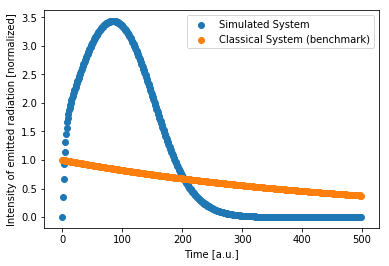

In [19]:
import tarfile

# get the results from S3
results = my_bucket.Object('superradiance/output/{}/output/model.tar.gz'.format(superradiance.latest_training_job.name))
tempfile = '/tmp/model.tar.gz'   
results.download_file('/tmp/model.tar.gz')    

# unzip the results
tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = '/tmp')

# load the results into the notebook
out = pickle.load(open('/tmp/out.pckl', "rb"))
intensity = out['intensity']
I_ind = out['I_ind']

# clean-up temporary files
os.remove(tempfile) 

# Vizualize the results
plt.scatter(range(steps-1),intensity/I_ind, label = 'Simulated System')
plt.scatter(range(steps-1), np.exp(-I_ind/N * np.arange(steps-1)), label = 'Classical System (benchmark)')
plt.xlabel('Time [a.u.]')
plt.ylabel('Intensity of emitted radiation [normalized]')
plt.legend()

plt.show()

*Fig 3.: Emission profile of the simulated particle ensemble (blue). The emission profile exhibits a strong burst of intensity when compared to the expected emission of a classical ensemble (orange)*

We can clearly see that the quantum system we have simulated exhibits a characteristic superradiance signature in the light emission profile (blue). As compared to the emission expected from an ensemble of classical particles (orange) the profile show a strong and distinct burst of radiation after a short time indicating superradiance.

## Conclusion

In this blog post you have seen that besides streamlining the machine learning workflow, Amazon SageMaker can be used as a general purpose and fully managed compute environment. You have learned how you can use the Amazon SageMaker “bring your own algorithm” functionality to containerize a scientific workload, define data input and output channels, and execute the workload on a SageMaker cluster. You have seen that these tasks in the workflow of a scientific computation can all be orchestrated from a single hosted Jupyter notebook.

If you have questions or suggestions, please leave a comment.

## Appendix: Tensorflow Code that Runs the Simulation

The program that is executed (`superradiance/train`) above uses Tensorflow to solve the quantum master equation of the spin system by simple sequential stepwise evolution. The code including explanations of the main steps is replicated below:

In [11]:
!cat container/superradiance/train

#!/usr/bin/env python

# A sample program that simulates a simple quantum system exhibiting superradiance

from __future__ import print_function
import os
import json
import pickle
import sys
import traceback
import tensorflow as tf
import numpy as np
from utils import kronecker_product, SparseIndices               
from scipy import sparse                                          
import pandas as pd                                               

# These are the paths to where SageMaker mounts interesting things in your container.

prefix = '/opt/ml/'

input_path = prefix + 'input/data'

output_path = os.path.join(prefix, 'output')                       # Failure output & error messages should be written here
model_path = os.path.join(prefix, 'model')                         # All results should be written here 
param_path = os.path.join(prefix, 
                          'input/config/hyperparameters.json')     # Passed parameters can be retrieved here

# This algorithm has a single